# **This notebook is intended for testing the functions of tools API built for AXO, and position calibration** #

In [1]:
import numpy as np
import time 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt


from science_jubilee.Machine import Machine
from science_jubilee.tools.Tool import Tool
from science_jubilee.decks.Deck import Deck
from science_jubilee.labware.Labware import Labware, Location, Well
from science_jubilee.tools.Pipette import Pipette
from science_jubilee.tools.Double_Syringe import DoubleSyringe
from science_jubilee.tools.Vacuum_Gripper import VacuumGripper
from science_jubilee.tools.Oceandirect_axo import Spectrometer

### **Manual Offset for coordinates (Look at Labware.py for details)** ###

In [32]:
deck = Deck("lab_automation_deck") # We are not using the deck, so operate any deck.json 

# -------------Position JSON file for Pipette ---------------------#
tiprack = deck.load_labware(labware_filename = 'opentrons_96_tiprack_1000ul_axo.json', slot = 5)   # Load an opentrons 20uL
tiprack.manual_offset2([[274.1, 219.8],[173.1, 220.0],[173.1, 282.0]], save = True)   # Save through list of list. List of coordinates should be A1 A12 H12 subsequently. 
samples_ot2 = deck.load_labware("uwsunlab_12_wellplate_4000ul_pipette_1.json", slot = 2)
samples_ot2.manual_offset2([[131.3, 135.5], [36.5, 135.8], [36.5, 176.8]], save = True)
samples2_ot2 = deck.load_labware("uwsunlab_12_wellplate_4000ul_pipette_2.json", slot = 0)
samples2_ot2.manual_offset2([[129.8, 40], [35.9, 38.8], [35.9, 79.8]], save = True)
solvent = deck.load_labware("uwsunlab_1_reservoir_60000ul.json", slot = 3)
solvent.manual_offset_small_plate([[225.2, 155.8]], save = True)
    
# -------------Position JSON file for Dual Syringe ---------------#
samples_sy = deck.load_labware('uwsunlab_12_wellplate_4000ul_1.json', slot = 2)
samples_sy.manual_offset2([[132.7, 132.6],[38.6, 132.6], [38.6, 174.2]], save = True)
samples2_sy = deck.load_labware('uwsunlab_12_wellplate_4000ul_2.json', slot = 0)
samples2_sy.manual_offset2([[132.2, 36.3], [38.2, 36.3], [38.2, 77.5]], save = True)
precursors = deck.load_labware('uwsunlab_2_wellplate_60000ul.json', slot = 1)
precursors.manual_offset_small_plate([[245.0, 60.0], [197.0, 60.0]], save = True)
# -----------Position JSON file for Spectrometer----------------# 
samples_spec = deck.load_labware('uwsunlab_12_wellplate_4000ul_spec_1.json', slot = 2)
samples_spec.manual_offset2([[128.3, 132.8],[34.0, 132.8], [34.0, 173.8]], save = True)
samples2_spec = deck.load_labware('uwsunlab_12_wellplate_4000ul_spec_2.json', slot = 0)
samples2_spec.manual_offset2([[127.3, 35.6], [32.9, 35.6], [33.5, 77.4]], save = True)

# ----------Position JSON file for Vacuum Gripper---------------#

Manual offset applied to opentrons_96_tiprack_1000ul
Manual offset saved
Manual offset applied to uwsunlab_12_wellplate_4000ul
Manual offset saved
Manual offset applied to uwsunlab_12_wellplate_4000ul
Manual offset saved
Manual offset applied (1×1 plate),  x_adjust=0.0, y_adjust=0.0
Manual offset saved.
Manual offset applied to uwsunlab_12_wellplate_4000ul
Manual offset saved
Manual offset applied to uwsunlab_12_wellplate_4000ul
Manual offset saved
Manual offset applied (1×2 plate),  x_adjust=0.0, y_adjust=0.0
Manual offset saved.
Manual offset applied to uwsunlab_12_wellplate_4000ul
Manual offset saved
Manual offset applied to uwsunlab_12_wellplate_4000ul
Manual offset saved


# **Clear labwares on the Bed** #

### **Homing to map the X,Y,Z, V axis** ###

In [35]:
axo = Machine(address = '192.168.1.2')

In [36]:
axo.home_all()
axo.move_to(z=180) # Safest Z location

### **Load labwares to the deck** ###

In [37]:
deck = axo.load_deck("lab_automation_deck")

## ---------------------OT2 1000ul Pipette ----------------------------##
tiprack = axo.load_labware("opentrons_96_tiprack_1000ul_axo.json", 5)
tiprack.load_manualOffset()
samples_ot2 = axo.load_labware('uwsunlab_12_wellplate_4000ul_pipette_1.json', 2)
samples_ot2.load_manualOffset()
samples2_ot2 = axo.load_labware('uwsunlab_12_wellplate_4000ul_pipette_2.json', 0)
samples2_ot2.load_manualOffset()
solvent = axo.load_labware('uwsunlab_1_reservoir_60000ul.json', 3)
solvent.load_manualOffset()
trash = (-0.9, 55.8, 99)
## -------------------------------------------------------------------##
#pipette = Pipette(0, "Pipette", brand = "opentron", model = "config", max_volume= 20, min_volume= 0, zero_position = (0,0,0),\
#    blowout_position=None, drop_tip_position = None, mm_to_ul = None)# model = "config")

## ---------------------Dual Syringe Pump ----------------------------##
samples_sy = axo.load_labware('uwsunlab_12_wellplate_4000ul_1.json', 2)
samples_sy.load_manualOffset()
samples2_sy = axo.load_labware('uwsunlab_12_wellplate_4000ul_2.json', 0)
samples2_sy.load_manualOffset()
precursors = axo.load_labware('uwsunlab_2_wellplate_60000ul.json', 1)
precursors.load_manualOffset()
## ------------------------------------------------------------------##

## --------------------------Spectrometer -------------------------------##
samples_spec = axo.load_labware('uwsunlab_12_wellplate_4000ul_spec_1.json', 2)
samples_spec.load_manualOffset()
samples2_spec = axo.load_labware('uwsunlab_12_wellplate_4000ul_spec_2.json', 0)
samples2_spec.load_manualOffset()
## ----------------------------------------------------------------------##

## ------------------------Vacuum Gripper --------------------------------##
vacuum_location = [(84, 51, 0),  # Slot 0 (12 Well Plate)
                   (225, 57, 0), # Slot 1 (2 Precursor Container)
                   (84, 147, 0), # Slot 2 (12 Well Plate)
                   (225, 149, 0), # Slot 3 (1 Solvent Container)
                   (79, 244, 0)] # Slot 4 (Lid Containter)



Manual offset applied to opentrons_96_tiprack_1000ul
Manual offset applied to uwsunlab_12_wellplate_4000ul
Manual offset applied to uwsunlab_12_wellplate_4000ul
Manual offset applied (1×1 plate),  x_adjust=0.0, y_adjust=0.0
Manual offset applied to uwsunlab_12_wellplate_4000ul
Manual offset applied to uwsunlab_12_wellplate_4000ul
Manual offset applied (1×2 plate),  x_adjust=0.0, y_adjust=0.0
Manual offset applied to uwsunlab_12_wellplate_4000ul
Manual offset applied to uwsunlab_12_wellplate_4000ul


In [83]:
deck.safe_z # The highest height among the labware loaded to the deck

97.47

In [39]:
type(samples2_ot2[0])
print(samples_sy[11].bottom(5))
print(samples_sy[0].top(5))


Location(point=(35.599999999999994, 176.0, 10), labware=Well B6 form UWSUNLAB 12 Well Plate 4000 µL on slot 2)
Location(point=(129.9, 133.3, 55), labware=Well A1 form UWSUNLAB 12 Well Plate 4000 µL on slot 2)


Slope: 0.0671 ml/mm
Intercept: -0.2166 ml


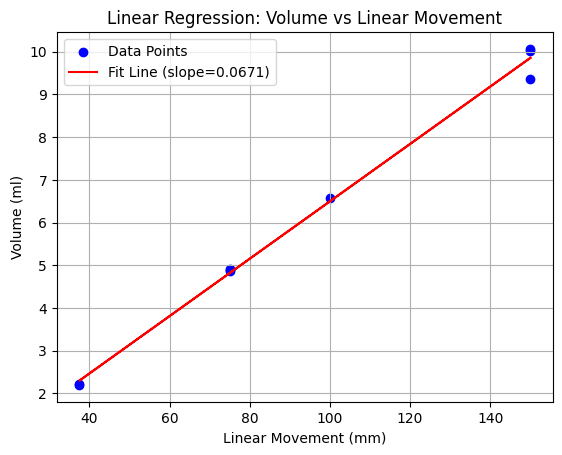

In [8]:
# Data: linear movement (mm) and corresponding volume (ml)
volume_ml = np.array([10.0658, 9.3605, 4.8707, 4.9170, 4.8899, 2.2181, 2.2002, 6.5860, 10.0196])
linear_movement_mm = np.array([150, 150, 75, 75, 75, 37.5, 37.5, 100, 150])

# Reshape for regression
X = linear_movement_mm.reshape(-1, 1)
y = volume_ml

# Linear regression
model = LinearRegression()
model.fit(X, y)

slope = model.coef_[0]
intercept = model.intercept_

print(f'Slope: {slope:.4f} ml/mm')
print(f'Intercept: {intercept:.4f} ml')

# Plot
plt.scatter(X, y, color='blue', label='Data Points')
plt.plot(X, model.predict(X), color='red', label=f'Fit Line (slope={slope:.4f})')
plt.xlabel('Linear Movement (mm)')
plt.ylabel('Volume (ml)')
plt.title('Linear Regression: Volume vs Linear Movement')
plt.legend()
plt.grid(True)
plt.show()

### **Before using the tools, always check the functions**

#### **Load Dual Syringe Pump to the machine** ####

In [82]:
syringe = DoubleSyringe(index = 2, 
                        name = 'Syringe_Pump', 
                        config = '10cc_syringe')
# You always need to load your tool to the machine
axo.load_tool(syringe)

In [26]:
# Check initiated attributes
print(syringe.max_range)
print(syringe.min_range)
print(syringe.mm_to_ml)
print(syringe.e0_drive)
print(syringe.e1_drive)

150
0
15
E0
E1


In [9]:
syringe.check_bounds(0) # Lower Bound
syringe.check_bounds(150) # Upper Bound

In [27]:
pos = axo.get_position()
print(float(pos['E0']))
print(float(pos['E1']))

30.0
45.0


### **Pick Up Dual Syringe Pump** ###

In [ ]:
axo.pickup_tool(syringe)

In [16]:
axo.move_to(x=150, y=150)

In [25]:
# When tool is active, the extruder assigned to driver (Working)
axo.move(de0=-75)

### **Check if aspirate is working** ###

### Right Syringe

In [ ]:
# Without active-tool E0 (Working)
#syringe._aspirate(vol = 10, drive = 'E0', s = 500)

Current_pos = 0.0


5.0

### Left Syringe

In [ ]:
#syringe._aspirate(vol = 5, drive = 'E1', s = 500)

#### **"aspirate_e0" goes to desired labware location and performs aspirate for Right Syringe** ####

####  **Loaded "precursors" json file are class type 'Labware' which represent a basic laboratory labware made up of set of wells/pipette tips, but each well of labware (e.g precursors['A1'], precursors[0]) are class type 'Well' which object with various information about the geometry of the well and its position in the labware** ##

#### **top(..) indicates the tools to dynamically offset relativally top-most point of the well** ###
#### **bottom(..) indicates the tools to offset from the bottom of the well.** ###

In [11]:
print(precursors[0].top_) # top-most z location (bottom + depth)
print(precursors[0].bottom_) # bottom z location (bottom)

53
8


In [66]:
syringe.aspirate_e0(1, precursors[1].top(1), s=500)

1.0

In [68]:
syringe.aspirate_e0(1, precursors[1], s=500)

1.0

In [67]:
syringe.aspirate_e1(1, precursors[0].top(1), s=500)

1.0

### **aspirate_e1 goes to desired labware location and performs aspirate for Left Syringe** ###

In [30]:
syringe.aspirate_e1(5, precursors[0], s=500)

ToolStateError: Error: Tool Syringe_Pump is not the current `Active Tool`. Cannot perform this action

#### **Actually you only need to use "dispense_e0" or "dispense_e1". Those function automatically aspirate (refill to the end) from solution containers and returns back to the position where we want to dispense** ####

#### **Dispense_e0 & Dispense_e1 performs automatic refill** #### 

##### First Dispenses at wellplate located at deck slot 2 

In [ ]:
syringe.dispense_e0(1, samples_sy[0].top(2), precursors[0], s=500)

5.0

In [62]:
syringe.dispense_e1(1, samples_sy['B6'].top(2), precursors[0], s=500)

1.0

In [ ]:
syringe.dispense_e1(1, samples2_sy['A1'].top(-10), precursors[0], s=500)

1.0

In [69]:
syringe.dispense_e1(1, samples2_sy['A6'].top(-10), precursors[0], s=500)

1.0

In [70]:
syringe.dispense_e1(1, samples2_sy['B6'].top(-10), precursors[0], s=500)

1.0

#### For 12 Well Plate Dispense & Refill routine ####

In [84]:
for i in range(6):
    syringe.dispense_e1(1, samples_sy[i].top(1), precursors[0], s= 300)
    syringe.dispense_e0(1, samples_sy[i].top(1), precursors[0], s= 300)

##### Next Dispenses at wellplate located at deck slot 0 

In [72]:
syringe.dispense_e0(1, samples2_sy[0].top(2), precursors[1], s=500)

1.0

In [73]:
syringe.dispense_e1(1, samples2_sy[0].top(2), precursors[0], s=500)

1.0

In [74]:
syringe.dispense_e1(1, samples2_sy['A6'].top(2), precursors[0], s=500)

1.0

In [75]:
syringe.dispense_e1(1, samples2_sy['B6'].top(2), precursors[0], s=500)

1.0

### **Check the dual syringe routine** ### 
#### ***Assume we are dispensing two solutions to the well plate*** ####

In [ ]:
# z = 40 dispensing location was the best, so top(-10)
for i in range(12):
    syringe.dispense_e1(1, samples_sy[i].top(-10), precursors[0], s = 500)
    syringe.dispense_e0(1, samples_sy[i].top(-10), precursors[0], s = 500)
# Took 5m 13.1s for dispensing all the solution in 12 well plate

In [21]:
# Z = 1.0 aspirate location was the best, json file bottom z location changed
syringe.aspirate_e1(1, precursors[0], s = 500)

1.0

In [23]:
syringe.aspirate_e0(1, precursors[1], s = 500)

1.0

In [26]:
syringe.dispense_e1(1, samples_sy[5].top(-20), precursors[0], s=500)

1.0

#### **Check for slot0 wellplate** ####

In [85]:
for i in range(12):
    syringe.dispense_e1(1, samples2_sy[i].top(-10), precursors[0], s = 500)
    syringe.dispense_e0(1, samples2_sy[i].top(-10), precursors[0], s = 500)

### **After all experiments are done return all the drives in 0 position** ###

In [86]:
syringe.reset_position()

In [87]:
axo.park_tool()

# **Spectrometer (Install the API from Oceandirect)** #

In [38]:
spectrometer = Spectrometer(index = 3, 
                            name = 'Spectrometer', 
                            base_dir=r"C:\Users\ADITI\Downloads\Aditya\Axo_Jubilee\science-jubilee\axo\spectrum_data",
                            plate_id = 'testing',
                            ref_dark = 'dark_20250528_144107.npy',
                            ref_white = 'white_20250528_144214.npy')
axo.load_tool(spectrometer)

Opened Spectrometer 2


### **Check your reference_spectrum (dark, white).** 
#### **If doesn't exist, measure it and save it through base_dir/ref** ##

In [13]:
print(spectrometer.dark)

[-114.1123017  -142.80711771 -123.48161073 ... -192.50976912 -223.82180138
 -223.40350395]


In [14]:
print(spectrometer.white)

[-174.08283305 -203.07899527 -177.87063677 ... -236.17748948 -284.79694935
 -284.37865305]


In [99]:
print(spectrometer.dark_id)
print(spectrometer.white_id)

dark_20250528_144107
white_20250528_144214


In [39]:
axo.pickup_tool(spectrometer)

### **Configure your spectrometer's parameters** ###
#### **You can use the Default version** ####

In [40]:
spectrometer.configure_device()

In [41]:
spectrometer.set_dark() 

'dark_20250625_133007'

In [42]:
spectrometer.set_white()

'white_20250625_133010'

In [46]:
spectrometer.position_probe(samples_spec[0].top(-5))

In [98]:
spectrometer.position_probe(samples2_spec['B6'].top(2))

### **Spectrometer Probe to well plate (Use this for positioning)** ###

#### Probe to wellplate located at Deck slot 2 (This is just probing the spectrometers befroe measurement)

In [27]:
for i in range(12):
    spectrometer.position_probe(samples_spec[i].top(2))

#### Probe to wellplate located at Deck slot 0 (This is just probing the spectrometers befroe measurement)

In [31]:
for i in range(12):
    spectrometer.position_probe(samples2_spec[i].top(2))

### **Now collect_spectrum will perform measurements and probes** ###

In [47]:
spectrometer.collect_spectrum(samples_spec[0].top(-5), 15, save= True)

(array([ 194.02957153,  194.57849831,  195.1273039 , ..., 1102.96248167,
        1103.3101147 , 1103.657674  ], shape=(2068,)),
 array([ -66.74080026,  -95.43544385,  -84.94428105, ..., -152.40592872,
        -176.75078307, -177.16908057], shape=(2068,)))

In [95]:
spectrometer.position_probe(samples_spec['A6'].top(2))

In [22]:
samples_spec[0].top(2)._labware

Well A1 form UWSUNLAB 12 Well Plate 4000 µL on slot 2

In [19]:
samples_spec[0].name

np.str_('A1')

In [104]:
for i in range(12):
    spectrometer.collect_spectrum(samples_spec[i].top(2), 15, save= True)

for i in range(12):
    spectrometer.collect_spectrum(samples2_spec[i].top(2), 16, save = True)

In [23]:
tiprack[0].name

np.str_('A1')

In [23]:
str(samples_spec[0].name)

'A1'

In [20]:
spectrometer.current_location.labware.name

np.str_('A5')

In [18]:
type(spectrometer.current_location.labware)

science_jubilee.labware.Labware.Well

### **Park the spectrometer** ###

In [22]:
axo.park_tool()

## **Pick Up Vacuum Gripper** ##

In [24]:
gripper = VacuumGripper(index = 4, 
                        name = 'Vacuum_Gripper', 
                        vacuum_pin = 0,
                        limit_switch_pin = 2)
axo.load_tool(gripper)

In [ ]:
axo.pickup_tool(gripper)

In [ ]:
gripper.grip(vacuum_location[4])
gripper.drop(vacuum_location[0])

(1, 0, 0)


In [ ]:
gripper.pick_and_place(vacuum_location[4],
                       vacuum_location[2])

In [ ]:
gripper.pick_and_place(vacuum_location[4],
                       vacuum_location[1])
gripper.pick_and_place(vacuum_location[4],
                       vacuum_location[3])

In [23]:
axo.park_tool()

## **Pipette Opentron OT2** ## 

In [106]:
P1000 = Pipette.from_config(0, 'Pipette', 'P1000_config.json')
axo.load_tool(P1000)
P1000.add_tiprack(tiprack)
P1000.trash = trash

In [135]:
axo.pickup_tool(P1000)

#### **First, check if pipette is picking the correct position of tiprack A1** #### 

In [121]:
P1000.pickup_tip(tiprack['A1'])

In [122]:
P1000.return_tip(tiprack['A1'])

#### **Manually find the coordinates of the center of three corners [[A1], [A12], [H12]] and set it to labware.manual_offset** ####

#### **Use 'labware.manual_offset_small_plate' for 1Xn, 1x1, nx1 well plates** 

#### **Test pickup and return tip** ####

In [22]:
for i in range(1, 4):
    P1000.pickup_tip(tiprack[i])
    P1000.return_tip(tiprack[i])
    P1000.pickup_tip(tiprack[i+11])
    P1000.return_tip(tiprack[i+11])

#### **Do the same positioning for labwares that we planning to dispense or aspirate** ####

In [123]:
P1000.pickup_tip(tiprack['A7'])

In [124]:
P1000.aspirate(vol = 300, location = solvent[0].top(-35), s=4000)

In [125]:
P1000.dispense(vol = 10, location = samples_ot2[0].top(-30), s = 4000)

In [126]:
P1000.dispense(vol = 10, location = samples_ot2['A6'].top(-30), s = 4000)

In [127]:
P1000.dispense(vol = 10, location = samples_ot2['B6'].top(-30), s = 4000)

In [ ]:
P1000.dispense(vol = 10, location = samples_ot2[3].top(-30), s = 4000)

In [25]:
for i in range(4, 12):
    P1000.dispense(vol = 10, location = samples_ot2[i].top(-30), s = 4000)

In [26]:
P1000.return_tip(tiprack['A1'])

### **Slot 0 Well plate testing** ###

In [128]:
P1000.dispense(vol = 10, location = samples2_ot2[0].top(-30), s = 4000)

In [129]:
P1000.dispense(vol = 10, location = samples2_ot2['A6'].top(-30), s = 4000)

In [130]:
P1000.dispense(vol = 10, location = samples2_ot2['B6'].top(-30), s = 4000)

In [132]:
P1000.mix(300, 3)

In [ ]:
for i in range(12):
    P1000.dispense(vol = 10, location = samples2_ot2[i].top(-40), s = 4000)
    P1000.mix(300, 3)

In [133]:
P1000.drop_tip(trash)

In [136]:
axo.park_tool()